In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassandra-bizli/cassandra-25-ps-2/sample_submission.csv
/kaggle/input/cassandra-bizli/cassandra-25-ps-2/training_set.csv
/kaggle/input/cassandra-bizli/cassandra-25-ps-2/test.csv


In [3]:
train_df = pd.read_csv("/kaggle/input/cassandra-bizli/cassandra-25-ps-2/training_set.csv")
test_df = pd.read_csv("/kaggle/input/cassandra-bizli/cassandra-25-ps-2/test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Id                 175341 non-null  int64  
 1   time_span          175341 non-null  float64
 2   proto_label        175341 non-null  object 
 3   svc_type           175341 non-null  object 
 4   conn_state         175341 non-null  object 
 5   src_pkts           175341 non-null  int64  
 6   dst_pkts           175341 non-null  int64  
 7   src_bytes          175341 non-null  int64  
 8   dst_bytes          175341 non-null  int64  
 9   conn_rate          175341 non-null  float64
 10  src_ttl            175341 non-null  int64  
 11  dst_ttl            175341 non-null  int64  
 12  src_load           175341 non-null  float64
 13  dst_load           175341 non-null  float64
 14  src_loss           175341 non-null  int64  
 15  dst_loss           175341 non-null  int64  
 16  sr

In [5]:
train_df.traffic_label.value_counts()

traffic_label
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


In [7]:

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Train and test categorical columns
categorical_cols = ['proto_label', 'svc_type', 'conn_state']

# Convert categorical columns to string to avoid mixed types issue
for col in categorical_cols:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Dictionary to store encoders
le_dict = {}

# Encode common categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], test_df[col]]))  # Fit on combined train + test
    train_df[col] = le.transform(train_df[col])  # Transform train
    le_dict[col] = le  # Store encoder for later use

# Encode 'traffic_label' (only in train)
le_label = LabelEncoder()
train_df['traffic_label'] = le_label.fit_transform(train_df['traffic_label'])


In [8]:
print(dict(zip(le_label.classes_, le_label.transform(le_label.classes_))))


{'Analysis': 0, 'Backdoor': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [9]:
# Features and Target
X = train_df.drop(['Id', 'traffic_label'], axis=1)
y = train_df['traffic_label']

# Encode target labels
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [10]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import numpy as np

# ✅ Extract features and labels
X_full = train_df.drop(columns=['Id', 'traffic_label'])  # Change if your label column is different
y_full = train_df['traffic_label']


# ✅ Encode labels
from sklearn.preprocessing import LabelEncoder
le_label = LabelEncoder()
y_encoded = le_label.fit_transform(y_full)

# ✅ Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ✅ Compute class weights for y_train
class_weights = {
    cls: (len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)[cls]))
    for cls in np.unique(y_train)
}

# ✅ Convert class weights to a list in order
scale_pos_weight = [class_weights[i] for i in range(len(class_weights))]

# ✅ Define XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    max_depth=12,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.8,
    n_estimators=1200,
    scale_pos_weight=scale_pos_weight,
    reg_lambda=6,
    reg_alpha=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# ✅ Fit model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=30,
    verbose=50
)

# ✅ Predict
y_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=1)

# ✅ Evaluation
print("🔹 Classification Report:")
target_names = le_label.classes_.astype(str)
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=1))

print("✅ Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("✅ ROC AUC Score:", roc_auc_score(y_test, y_proba, multi_class='ovr'))


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:54:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.23078
[50]	validation_0-mlogloss:0.96432
[100]	validation_0-mlogloss:0.64171
[150]	validation_0-mlogloss:0.51998
[200]	validation_0-mlogloss:0.46887
[250]	validation_0-mlogloss:0.44503
[300]	validation_0-mlogloss:0.43287
[350]	validation_0-mlogloss:0.42609
[400]	validation_0-mlogloss:0.42188
[450]	validation_0-mlogloss:0.41925
[500]	validation_0-mlogloss:0.41738
[550]	validation_0-mlogloss:0.41620
[600]	validation_0-mlogloss:0.41540
[650]	validation_0-mlogloss:0.41485
[700]	validation_0-mlogloss:0.41452
[750]	validation_0-mlogloss:0.41433
[800]	validation_0-mlogloss:0.41430
[820]	validation_0-mlogloss:0.41430
🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.14      0.22       400
           1       0.85      0.10      0.18       349
           2       0.33      0.15      0.21      2453
           3       0.63      0.89      0.74      6679
           4       0.78      0.76      0.77      3637
     

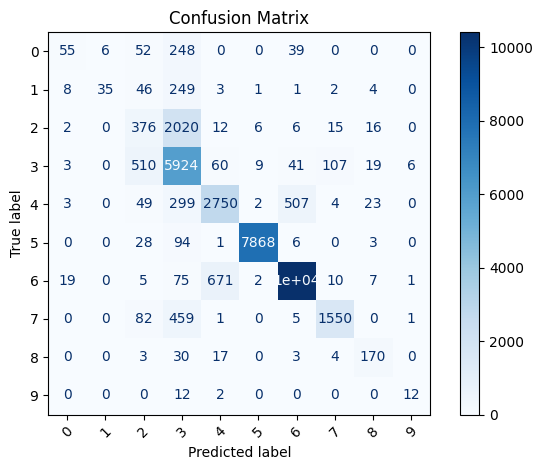

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔹 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_label.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.0726 - val_accuracy: 0.6456 - val_loss: 0.0397 - learning_rate: 5.0000e-04
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6559 - loss: 0.0415 - val_accuracy: 0.6463 - val_loss: 0.0381 - learning_rate: 5.0000e-04
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6931 - loss: 0.0383 - val_accuracy: 0.6442 - val_loss: 0.0376 - learning_rate: 5.0000e-04
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7009 - loss: 0.0377 - val_accuracy: 0.6449 - val_loss: 0.0377 - learning_rate: 5.0000e-04
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7009 - loss: 0.0374 - val_accuracy: 0.6453 - val_loss: 0.0380 - learning_rate: 5.0000e-04
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7091 - loss: 0.0369 - val_accuracy: 0.6468 - val_loss: 0.0365 - learning_rate: 5.0000e-04
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.708

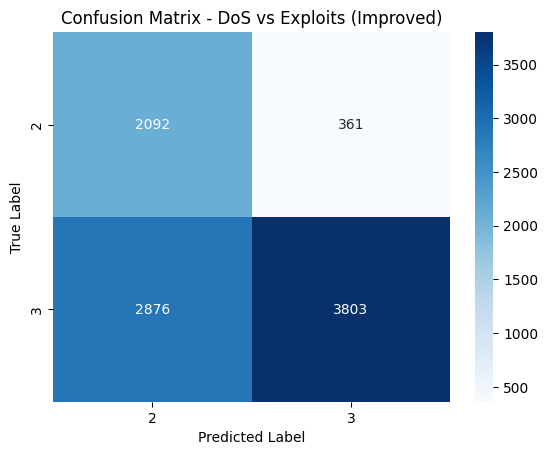

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ SMOTE to oversample minority class
smote = SMOTE(random_state=42)
X_train_bin_res, y_train_bin_res = smote.fit_resample(X_train_bin, y_train_bin)

# ✅ Define focal loss
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

# ✅ Better model architecture
model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_bin.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                 loss=focal_loss(gamma=2., alpha=0.25),
                 metrics=['accuracy'])

# ✅ Train with early stopping
model_nn.fit(
    X_train_bin_res, y_train_bin_res,
    validation_data=(X_test_bin, y_test_bin),
    epochs=100,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
    ],
    verbose=1
)

# ✅ Evaluate
y_proba_nn = model_nn.predict(X_test_bin).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

print("\n🔹 Classification Report:")
print(classification_report(y_test_bin, y_pred_nn, target_names=le_bin.classes_.astype(str), zero_division=1))
print("✅ Weighted F1 Score:", f1_score(y_test_bin, y_pred_nn, average='weighted'))
print("✅ ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_nn))

# ✅ Confusion Matrix Plot
cm = confusion_matrix(y_test_bin, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_bin.classes_, yticklabels=le_bin.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - DoS vs Exploits (Improved)')
plt.show()


              precision    recall  f1-score   support

           0       0.43      0.80      0.56      2453
           1       0.89      0.61      0.72      6679

    accuracy                           0.66      9132
   macro avg       0.66      0.71      0.64      9132
weighted avg       0.77      0.66      0.68      9132



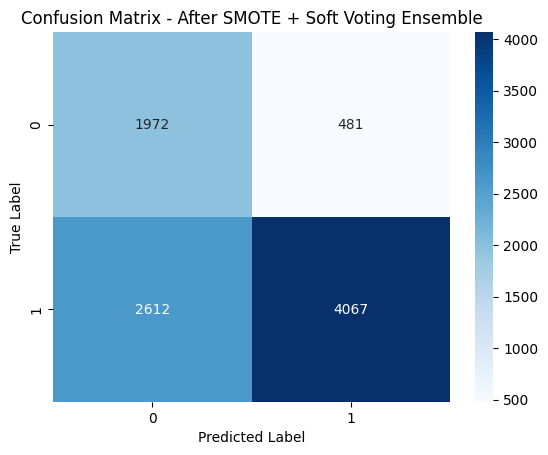

In [25]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Encode labels to integers
le_bin = LabelEncoder()
y_train_encoded = le_bin.fit_transform(y_train_bin)
y_test_encoded = le_bin.transform(y_test_bin)

# Step 2: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bin)
X_test_scaled = scaler.transform(X_test_bin)

# Step 3: Balance data using SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train_encoded)

# Step 4: Define classifiers (ensure class balance handling)
model1 = RandomForestClassifier(n_estimators=1200, random_state=42, class_weight='balanced')
model2 = XGBClassifier(
    n_estimators=900,
    learning_rate=0.09,
    max_depth=8,
    random_state=42,
    objective='multi:softprob',
    num_class=len(le_bin.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss'
)
model3 = LogisticRegression(max_iter=2000, class_weight='balanced')

# Step 5: Voting Ensemble (soft voting)
voting_model = VotingClassifier(estimators=[
    ('rf', model1), ('xgb', model2), ('lr', model3)
], voting='soft')

# Step 6: Train the ensemble
voting_model.fit(X_train_balanced, y_train_balanced)

# Step 7: Predict
y_pred_ensemble = voting_model.predict(X_test_scaled)

# Step 8: Evaluation
print(classification_report(y_test_encoded, y_pred_ensemble, target_names=le_bin.classes_.astype(str)))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_bin.classes_, yticklabels=le_bin.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - After SMOTE + Soft Voting Ensemble')
plt.show()


📊 Confusion Matrix:
 [[1443 1010]
 [1784 4895]]


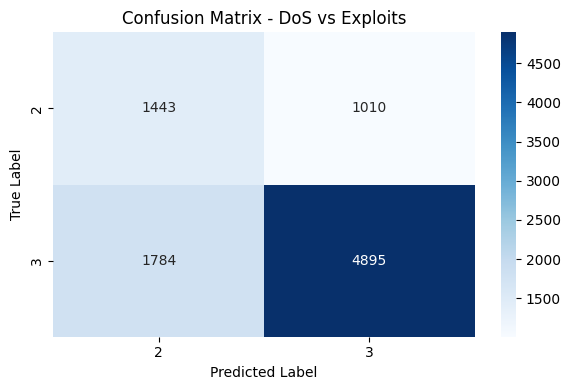

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("📊 Confusion Matrix:\n", cm)

# Optional: plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_bin.classes_,
            yticklabels=le_bin.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DoS vs Exploits")
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === PREDICTION ON UNSEEN TEST CSV ===

# ✅ Your manual decoding dictionary
label_map = {
    0: 'Analysis',
    1: 'Backdoor',
    2: 'DoS',
    3: 'Exploits',
    4: 'Fuzzers',
    5: 'Generic',
    6: 'Normal',
    7: 'Reconnaissance',
    8: 'Shellcode',
    9: 'Worms'
}

# ✅ Save Ids for final submission
test_ids = test_df['Id']

# ✅ Drop Id column to get features
X_submit = test_df.drop(columns=['Id'])

# ✅ Encode categorical columns using previously fitted LabelEncoders
cat_columns = ['proto_label', 'svc_type', 'conn_state']
for col in cat_columns:
    X_submit[col] = le_dict[col].transform(X_submit[col])

# ✅ Step 1: Multi-class model prediction
y_submit_encoded = model.predict(X_submit)

# ✅ Manually decode predictions using dictionary
y_submit_labels = np.array([label_map[val] for val in y_submit_encoded])

# ✅ Find indices where predicted label is DoS or Exploits
dos_exploits_idx = np.where((y_submit_labels == 'DoS') | (y_submit_labels == 'Exploits'))[0]

# ✅ Step 2: Refine DoS vs Exploits predictions using binary model
if len(dos_exploits_idx) > 0:
    X_bin_submit = X_submit.iloc[dos_exploits_idx]
    y_bin_pred = model_bin.predict(X_bin_submit)

    # Binary decoding: 0 = 'DoS', 1 = 'Exploits'
    bin_label_map = {0: 'DoS', 1: 'Exploits'}
    y_bin_labels = np.array([bin_label_map[val] for val in y_bin_pred])

    y_submit_labels[dos_exploits_idx] = y_bin_labels

# ✅ Create final submission DataFrame
submission_df = pd.DataFrame({
    'Id': test_ids,
    'traffic_label': y_submit_labels
})

# ✅ Save to CSV
submission_df.to_csv('submission.csv', index=False)

# ✅ Display sample output
print("📁 Submission file saved as 'submission.csv'")
print(submission_df.head())


📁 Submission file saved as 'submission.csv'
   Id traffic_label
0   1        Normal
1   2           DoS
2   3      Exploits
3   4       Generic
4   5      Backdoor
